In [1]:
import os
import sys
from sys import path
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
from scipy.optimize import least_squares
import json
import coord_helper as ch
import random
import h5py
from scripts.xcorr import helper as hp

BDC is using numpy
BDC is using numpy


In [2]:
config_file_name = 'config_mars_1bit_16993.json'
baseline_idx = 1

In [4]:
with open(f"./config/{config_file_name}", "r") as f:
    config = json.load(f)
    dir_parents = []
    coords = []
    # unpack information from the json file
    # Call get_starting_index for all antennas except reference
    for i, (ant, details) in enumerate(config["antennas"].items()):
        if (i == 0) or (i ==baseline_idx):
            coords.append(details['coordinates'])
            dir_parents.append(details["path"])
    global_start_time = config["correlation"]["start_timestamp"]
    end_t = config["correlation"]["end_timestamp"]
    c_acclen = config["correlation"]["coarse_acclen"]
    v_acclen = config["correlation"]["vis_acclen"]
    visibility_window = config["correlation"]["visibility_window"]
    T_SPECTRA = config["correlation"]["point_PFB"] / config["correlation"]["sample_rate"]

print("Antenna Paths:", dir_parents)
print("Antenna Coordinates:", coords)
print("Visibility Accumulation Length", v_acclen)
print("Coarse Accumulation Length:", c_acclen)
print(global_start_time)

Antenna Paths: ['/project/s/sievers/albatros/mars/202307/baseband/stn_1_central', '/project/s/sievers/albatros/mars/202307/baseband/stn_2_east']
Antenna Coordinates: [[79.41718333333333, -90.76735, 189], [79.41721666666666, -90.75885, 176]]
Visibility Accumulation Length 30000
Coarse Accumulation Length: 1000000
1699300100


In [5]:
ref_coords = coords[0]
a2_coords = coords[1]

ref_path = dir_parents[0]
a2_path = dir_parents[1]

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

context = [global_start_time, visibility_window, [T_SPECTRA, v_acclen, v_nchunks], ref_coords, tle_path]

In [6]:
with open(f"./pulsedata/pulsedata_{global_start_time}_1749069124.json", "r") as f:
    pulsedata = json.load(f)
    
    info = []
    offsets = []
    for pulse_idx, details in enumerate(pulsedata[f"{global_start_time}"]["antenna 1"]):
        #print(f"\n--------pulse idx {pulse_idx}---------")
        start_time = details["start"] * 5
        end_time = details["end"] * 5
        rel = False

        #For now, disregard multiple sat passes. For v2.
        if len(details["sats_present"]) > 1:
            continue

        for satID, values in details["sats_present"].items():
            
            for i in range(len(values)):
                pulse_info = []
                #print(values[i])
                chan = values[i][0]
                corr_offset = values[i][1]
                if values[i][2][0] > 0.9:
                    rel = True
                pulse_info.append([start_time, end_time])
                pulse_info.append(int(satID))
                pulse_info.append(chan)
                pulse_info.append(corr_offset)

                info.append(pulse_info)

        if rel==True:
            offsets.append(details["timestream_offset"])
            
print(info)
print(offsets)
specnumoffset = int(stats.mode(offsets)[0])
print(specnumoffset)
#first pulse with overflowed specnumoffset is index 24.
print(len(info))

[[[245, 805], 33591, 1849, 39200], [[245, 805], 33591, 1850, 39200], [[2200, 2740], 25338, 1841, 62057], [[4740, 5275], 57166, 1836, 101088], [[4740, 5275], 57166, 1837, 101088], [[6285, 6845], 33591, 1849, 84378], [[6285, 6845], 33591, 1850, 84327], [[7055, 7430], 28654, 1836, 53294], [[7055, 7430], 28654, 1837, 53294], [[7055, 7430], 28654, 1846, 53294], [[8190, 8735], 25338, 1841, 86608], [[10735, 11270], 57166, 1836, 78278], [[10735, 11270], 57166, 1837, 78278], [[12330, 12895], 33591, 1850, 25625], [[13095, 13625], 28654, 1836, 97502], [[13095, 13625], 28654, 1837, 97426], [[14210, 14740], 25338, 1841, 91217], [[16745, 17280], 57166, 1836, 46335], [[16745, 17280], 57166, 1837, 46335], [[19140, 19705], 28654, 1836, 90713], [[19140, 19705], 28654, 1837, 90662], [[20280, 20750], 25338, 1841, 115270], [[22795, 23300], 57166, 1837, 114772], [[24520, 25020], 33591, 1850, 75727], [[25215, 25765], 28654, 1836, 34736], [[26425, 26755], 25338, 1841, 62335], [[28905, 29320], 57166, 1836, 436

In [80]:
pulse_idx = 2

print(f"---------STARTING PULSE {pulse_idx}---------")

#--------times-----
relative_start_time = info[pulse_idx][0][0]
pulse_duration_chunks = int((info[pulse_idx][0][1] - info[pulse_idx][0][0]) / (T_SPECTRA * v_acclen)  )
print("number of chunks for pulse:", pulse_duration_chunks)
t_start = global_start_time + relative_start_time
print("relative start time:", t_start)
t_end = t_start + visibility_window

#----get initialized information----
files_a1, idx1 = butils.get_init_info(t_start, t_end, ref_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)

#------get corrected offsets-----
idx_correction = info[pulse_idx][3] - 100000
if idx_correction>0:
    idx1 = idx1 + idx_correction
else:
    idx2 = idx2 + np.abs(idx_correction)

#-------set up channels-------
channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
nchans=chanend-chanstart


#need to verify how the 1bit data gets this actually

chan_bigidx = info[pulse_idx][2]
print("Large Channel idx", chan_bigidx)
chanmap = channels[chanstart:chanend].astype(int)
chan_smallidx = np.where(chanmap == chan_bigidx)[0][0]
print("Small Channel idx", chan_smallidx)

#--------call get_avg_fast----------

time_pulse=time.time()

pols, data, channels = hp.get_avg_fast(ref_path, a2_path, t_start, t_end, specnumoffset, v_acclen, v_nchunks, chanstart=chanstart, chanend=chanend)

print(f"DONE PULSE {pulse_idx}. TIME:", time.time()-time_pulse)

---------STARTING PULSE 2---------
number of chunks for pulse: 1098
relative start time: 1699302300
Not reading any data
Large Channel idx 1841
Small Channel idx 7
took 0.198 seconds to read raw data on  /project/s/sievers/albatros/mars/202307/baseband/stn_1_central/16993/1699302243.raw
took 0.850 seconds to read raw data on  /project/s/sievers/albatros/mars/202307/baseband/stn_2_east/16993/1699302267.raw
before correction 3479004 2014160
after correction 3479004 2052103
Starting at:  3479004 in filenum:  /project/s/sievers/albatros/mars/202307/baseband/stn_1_central/16993/1699302243.raw for antenna 1
Starting at:  2052103 in filenum:  /project/s/sievers/albatros/mars/202307/baseband/stn_2_east/16993/1699302267.raw for antenna 2
ACCLEN RECEIVED IS 30000
took 0.194 seconds to read raw data on  /project/s/sievers/albatros/mars/202307/baseband/stn_1_central/16993/1699302243.raw
START SPECNUM IS 1404466389 obj start at 1400987385
ACCLEN RECEIVED IS 30000
took 0.161 seconds to read raw data

In [104]:
vis0 = np.ma.masked_invalid(pols[0])

In [128]:
angles0 = np.ma.masked_invalid(np.angle(vis0))
print(angles0[50:100, 7])

[2.5811829566955566 2.3728857040405273 2.2125282287597656
 1.728049397468567 2.4183871746063232 1.5578111410140991
 1.7771720886230469 1.6905925273895264 1.6176508665084839
 1.127754807472229 1.073461651802063 1.0933351516723633 0.6806551814079285
 0.07446664571762085 -0.047106873244047165 -0.2698326110839844
 0.11350658535957336 -0.13898395001888275 -0.7928134202957153
 -0.43507885932922363 -0.8575707674026489 -0.8206830620765686
 -0.9850640296936035 -1.5605119466781616 -1.6045337915420532 -- --
 -2.6949257850646973 -2.3302698135375977 -2.287454128265381
 3.008680582046509 2.577312469482422 2.720397472381592 2.877261161804199
 1.708505392074585 2.1674859523773193 1.6468284130096436
 1.4919134378433228 1.6736347675323486 0.8868436813354492
 0.6193487048149109 0.8155621886253357 0.6912641525268555
 -0.06426114588975906 0.42954957485198975 -0.05750696733593941
 -0.3046557307243347 -0.24114970862865448 -0.8848257064819336
 -0.9645149111747742]


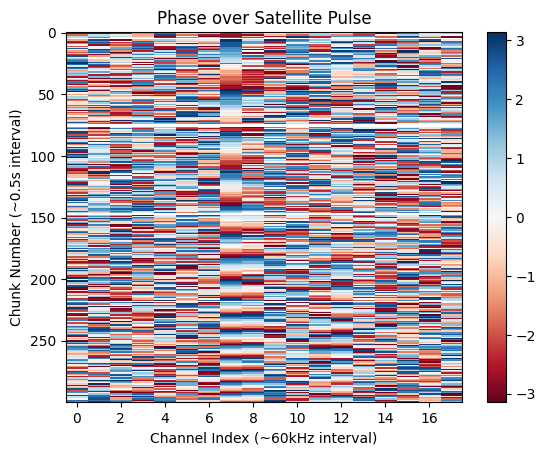

In [126]:
# vis_phase_1clk = np.angle(visibility_1clk)
plt.xlabel("Channel Index (~60kHz interval)")
plt.ylabel("Chunk Number (~0.5s interval)")
plt.title("Phase over Satellite Pulse")
plt.imshow(angles0[0:300], aspect='auto',cmap='RdBu',interpolation="none")

plt.colorbar()

In [87]:
obs = np.unwrap(vis0[:, 16])
obs.shape
print(vis0[:, 16])

[-1.8134372234344482 -0.673377513885498 0.5203658938407898
 -0.9260109663009644 2.1765236854553223 -- 2.745736598968506
 -2.992182493209839 -0.8844952583312988 -0.6175129413604736
 1.234904170036316 0.10768989473581314 -3.0338988304138184
 -2.9746222496032715 -2.3765931129455566 -0.4293363392353058
 -0.7531552910804749 0.6121712923049927 0.36255839467048645
 1.4787107706069946 1.9805541038513184 -1.756596565246582
 -3.126668691635132 -1.546412467956543 -2.265547513961792
 -2.184990406036377 2.0753555297851562 0.8459137082099915
 0.23571740090847015 -1.6711304187774658 0.0 1.7495794296264648
 2.6779491901397705 -2.322885513305664 2.4828038215637207
 -2.4723386764526367 0.9143137335777283 -1.192678451538086
 0.31204402446746826 0.014632941223680973 0.6301954388618469
 2.786895513534546 1.4994930028915405 -0.8834456205368042
 -1.9458128213882446 0.5404183864593506 2.508842945098877
 2.844228982925415 -1.3734008073806763 1.2734289169311523
 1.0303914546966553 -1.7878086566925049 -3.0883090

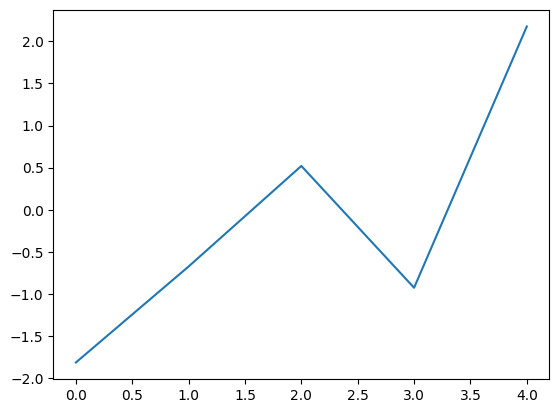

In [84]:
plt.plot(obs)